In [16]:
import pandas as pd 
from scipy.stats import pointbiserialr
from pathlib import Path
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Prep Data

In [2]:
notebook_dir = Path.cwd()
file_path = notebook_dir.parent / "data" / "speech_data.csv"
df = pd.read_csv(file_path)

# Subset data with Republican or Democratic Presidents 
df2 = df[(df["Political Party"] == "Republican")|(df["Political Party"] == "Democrat")].copy()

df2["Political Party"].unique()
df2.head()

,Name,Unifying Words Count,Polarizing Words Count,Total Words Count,Political Party,Overall Language,Unifying Words Ratio,Polarizing Words Ratio,Overall Ratio
0,Donald J. Trump (2nd Term),21,22,2905,Republican,polarizing,0.00723,0.00757,0.9551
1,"Joseph R. Biden, Jr.",29,11,2532,Democrat,unifying,0.01145,0.00434,2.6382
2,Donald J. Trump (1st Term),10,4,1455,Republican,unifying,0.00687,0.00275,2.4982
3,Barack Obama,16,5,2090,Democrat,unifying,0.00766,0.00239,3.2050
4,Barack Obama,15,18,2391,Democrat,polarizing,0.00627,0.00753,0.8327


In [3]:
# Encode Political Party as a binary variable for point biserial correlation analysis 

df2['Political Party'] = df2['Political Party'].map({'Republican': 0, 'Democrat': 1})
df2.head(3)

,Name,Unifying Words Count,Polarizing Words Count,Total Words Count,Political Party,Overall Language,Unifying Words Ratio,Polarizing Words Ratio,Overall Ratio
0,Donald J. Trump (2nd Term),21,22,2905,0,polarizing,0.00723,0.00757,0.9551
1,"Joseph R. Biden, Jr.",29,11,2532,1,unifying,0.01145,0.00434,2.6382
2,Donald J. Trump (1st Term),10,4,1455,0,unifying,0.00687,0.00275,2.4982


# Analysis I: Using all presidential speech data 

## Point Biserial Correlation Analysis

In [4]:
correlation, p_value = pointbiserialr(df2['Political Party'], df2['Overall Ratio'])

print("Correlation:", round(correlation, 5))
print("p-value:", round(p_value, 5))

Correlation: 0.05972
p-value: 0.68036


This did not yield very statistically significant results nor any strong relationship between political party and primary type of language used. Let's try some other methods...

## Logistic Regression

### Fit a Model with All Features
This is our "final" model, or the model that performed the best.

In [4]:
# Feature and target selection
X = df2.drop(columns=["Political Party", "Name", "Overall Language"]) # X = df2[["Political Party"]]
y = df2["Political Party"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train data and transform
X_test = scaler.transform(X_test)  # Only transform test data

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions)

# Evaluate the model
# print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:")
print("                 Predicted Negative  Predicted Positive")
print("Actual Negative      TN = {:<5}        FP = {:<5}".format(cm[0, 0], cm[0, 1]))
print("Actual Positive      FN = {:<5}        TP = {:<5}".format(cm[1, 0], cm[1, 1]))
# print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


Testing Accuracy: 0.4

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative      TN = 3            FP = 2    
Actual Positive      FN = 4            TP = 1    

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.33      0.20      0.25         5

    accuracy                           0.40        10
   macro avg       0.38      0.40      0.38        10
weighted avg       0.38      0.40      0.38        10



#### Show Predictions

In [20]:
len(X_test)

10

In [17]:
party_labels = np.where(predictions == 0, "Republican", "Democrat")

# Display predictions 
for i, label in enumerate(party_labels[:10]): 
    print(f"Sample {i+1}: Predicted Party -> {label}")


Sample 1: Predicted Party -> Republican
Sample 2: Predicted Party -> Republican
Sample 3: Predicted Party -> Republican
Sample 4: Predicted Party -> Democrat
Sample 5: Predicted Party -> Republican
Sample 6: Predicted Party -> Republican
Sample 7: Predicted Party -> Republican
Sample 8: Predicted Party -> Democrat
Sample 9: Predicted Party -> Democrat
Sample 10: Predicted Party -> Republican


#### Bias and Uncertainty

##### Calculating Bias

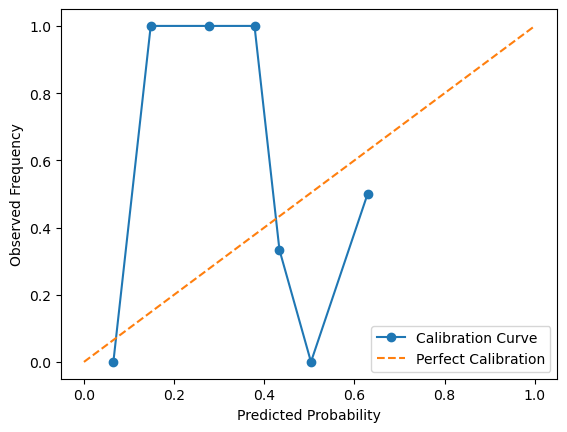

In [9]:
# Calibration Curve (Reliability Curve)
# Measures how well predicted probabilities match the true probabilities

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.legend()
plt.show()

In [15]:
# Brier Score
# Measures accuracy of predicted probabilities
from sklearn.metrics import brier_score_loss

brier_score = brier_score_loss(y_test, y_prob) # Lower values = lower bias
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.3158


##### Calculating Uncertainty

In [14]:
# Entropy 
# Measures uncertainty of predicted probabilities

from scipy.stats import entropy

# Convert probabilities to entropy
entropies = entropy([y_prob, 1 - y_prob], axis=0)
print(f"Entropy (Mean): {np.mean(entropies):.4f}") # Higher values = higher uncertainty

Entropy (Mean): 0.5973


### View Feature Importance 

In [10]:
# Extract feature coefficients
coefficients = model.coef_[0]
features = X.columns  # Fix: Use X instead of X_train to get feature names

# Create a DataFrame for better readability
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
# feature_importance['Absolute Coefficient'] = np.abs(feature_importance['Coefficient'])
# feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print("Feature Importance for Logistic Regression:")
print(feature_importance)


Feature Importance for Logistic Regression:
                  Feature  Coefficient
0    Unifying Words Count     0.312664
1  Polarizing Words Count    -0.300659
2       Total Words Count    -0.461904
3    Unifying Words Ratio     0.183516
4  Polarizing Words Ratio     0.978647
5           Overall Ratio     0.486419


### Fit a Model with Strongest Features: Unifying Words Count, Polarizing Words Count, and Overall Ratio

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Feature and target selection
X = df2[["Polarizing Words Ratio", "Overall Ratio", "Total Words Count"]] 
y = df2["Political Party"]

# Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train data and transform
X_test = scaler.transform(X_test)  # Only transform test data

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4002, stratify=y)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
# print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Testing Accuracy: 0.4

Confusion Matrix:
 [[2 3]
 [3 2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



Overall accuracy is higher fitting a model with only the strongest features, but precision, recall, and F1-score are 0 for Democratic party classifications, so we'll use the logistic regression model with all features.

# Analysis II: Using only 'modern' data 
We define modern presidential speech data as presidents after Richard Nixon.

In [12]:
# Subset first 15 rows of data 
df3 = df2.head(15).copy()
df3

,Name,Unifying Words Count,Polarizing Words Count,Total Words Count,Political Party,Overall Language,Unifying Words Ratio,Polarizing Words Ratio,Overall Ratio
0,Donald J. Trump (2nd Term),21,22,2905,0,polarizing,0.00723,0.00757,0.9551
1,"Joseph R. Biden, Jr.",29,11,2532,1,unifying,0.01145,0.00434,2.6382
2,Donald J. Trump (1st Term),10,4,1455,0,unifying,0.00687,0.00275,2.4982
3,Barack Obama,16,5,2090,1,unifying,0.00766,0.00239,3.2050
4,Barack Obama,15,18,2391,1,polarizing,0.00627,0.00753,0.8327
5,George W. Bush,13,13,2069,0,polarizing,0.00628,0.00628,1.0000
6,George W. Bush,14,5,1591,0,unifying,0.00880,0.00314,2.8025
7,William J. Clinton,26,3,2156,1,unifying,0.01206,0.00139,8.6763
8,William J. Clinton,8,9,1598,1,polarizing,0.00501,0.00563,0.8899
9,George Bush,14,2,2320,0,unifying,0.00603,0.00086,7.0116


## Point Biserial Correlation Analysis

In [13]:
correlation, p_value = pointbiserialr(df3['Political Party'], df3['Overall Ratio'])

print("Correlation:", round(correlation, 5))
print("p-value:", round(p_value, 5))

Correlation: 0.08839
p-value: 0.75408


This yielded worse results than including all data. Let's try logistic regression.

## Logistic Regression

### Fit a Kitchen Sink Model (all features)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Feature and target selection
X = df3.drop(columns=['Political Party', "Name", "Overall Language"]) # X = df2[["Political Party"]]
y = df3['Political Party']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train data and transform
X_test = scaler.transform(X_test)  # Only transform test data

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
# print("Training Accuracy:", model.score(X_train, y_train))
print("Testing Accuracy:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))


Testing Accuracy: 0.3333333333333333

Confusion Matrix:
 [[1 1]
 [1 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



Logistic regression also produces strange results with low accuracy. We will focus our analysis on data including all presidential speeches.